# Setup

In [6]:
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from pycocotools import mask as maskUtils
import torch
import random
import sys
import numpy as np
import supervision as sv
import time
import cv2
from typing import Tuple, Optional

np.set_printoptions(precision=15)

!nvidia-smi

Wed Apr 24 22:34:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   30C    P0    61W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [18]:
# import utils
import data_preprocess, class_agnostic_sam_predictor
from data_preprocess import preprocess_utils as preprocess
from class_agnostic_sam_predictor import predictor_utils as predict

# from preprocess_utils import *

In [19]:
OM_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'
OM_dir

'/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'

In [232]:
json_f = './-xmm_om_images_512_no_stars-6/train/_annotations.coco.json'
with open(json_f) as f:
    data_in = json.load(f)

target_json = './xmm_om_artefacts_512-10/train/_annotations.coco.json'
with open(target_json) as f:
    target_data_in = json.load(f)

In [233]:
data_in['categories']

[{'id': 0, 'name': 'star-MzbW', 'supercategory': 'none'},
 {'id': 1, 'name': 'other', 'supercategory': 'star-MzbW'},
 {'id': 2, 'name': 'read-out-streak', 'supercategory': 'star-MzbW'},
 {'id': 3,
  'name': 'scattered-light-outside-FOV',
  'supercategory': 'star-MzbW'}]

In [234]:
target_data_in['categories']

[{'id': 0, 'name': 'artefacts', 'supercategory': 'none'},
 {'id': 1, 'name': 'central-ring', 'supercategory': 'artefacts'},
 {'id': 2, 'name': 'smoke-ring', 'supercategory': 'artefacts'},
 {'id': 3, 'name': 'star-loop', 'supercategory': 'artefacts'}]

In [235]:
new_categories = target_data_in['categories'] + data_in['categories']
new_categories[4]['id'] = 3
new_categories[5]['id'] = 4
new_categories[6]['id'] = 5
new_categories[7]['id'] = 6
new_categories[4]['supercategory'] = 'artefacts'
new_categories[5]['supercategory'] = 'artefacts'
new_categories[6]['supercategory'] = 'artefacts'
new_categories[7]['supercategory'] = 'artefacts'
new_categories.remove({'id': 3, 'name': 'star-MzbW', 'supercategory':  'artefacts'})
new_categories

[{'id': 0, 'name': 'artefacts', 'supercategory': 'none'},
 {'id': 1, 'name': 'central-ring', 'supercategory': 'artefacts'},
 {'id': 2, 'name': 'smoke-ring', 'supercategory': 'artefacts'},
 {'id': 3, 'name': 'star-loop', 'supercategory': 'artefacts'},
 {'id': 4, 'name': 'other', 'supercategory': 'artefacts'},
 {'id': 5, 'name': 'read-out-streak', 'supercategory': 'artefacts'},
 {'id': 6,
  'name': 'scattered-light-outside-FOV',
  'supercategory': 'artefacts'}]

In [236]:
print(len([i for i in range(len(data_in['annotations'])) if data_in['annotations'][i]['category_id']==2]))

834


In [237]:
print(len([i for i in range(len(data_in['annotations'])) if data_in['annotations'][i]['category_id']==1]))

5


In [238]:
print(len([i for i in range(len(data_in['annotations'])) if data_in['annotations'][i]['category_id']==3]))

4


In [240]:
ros_annots = {}
already = 0
updated_annots = []
for i in range(len(target_data_in['images'])):
    target_img_id = target_data_in['images'][i]['id']
    image_from_annot_id = target_data_in['images'][i]['file_name'].split('.')[0]
    annots_per_cat = []
    
    for k in range(len(data_in['images'])):
        source_img_id = data_in['images'][k]['id']
        source_filename = data_in['images'][k]['file_name'].split('.')[0]
        annotations = [data_in['annotations'][j] for j in range(len(data_in['annotations'])) if data_in['annotations'][j]['image_id'] == source_img_id \
                       and data_in['annotations'][j]['category_id']==2]
        if len(annotations)>0 and source_filename==image_from_annot_id:
            ros_annots[image_from_annot_id] = annotations
            for ii in range(len(annotations)):
                annotations[ii]['image_id'] = target_img_id
                annotations[ii]['category_id'] = 5
                
            updated_annots.append(annotations)

In [241]:
updated_annots

[[{'id': 830,
   'image_id': 84,
   'category_id': 5,
   'bbox': [104, 21, 5.1, 235.69],
   'area': 1202.019,
   'segmentation': [[104.05,
     20.885,
     109.15,
     20.885,
     109.15,
     256.575,
     104.05,
     256.575]],
   'iscrowd': 0},
  {'id': 831,
   'image_id': 84,
   'category_id': 5,
   'bbox': [104, 296, 6.07, 210.95],
   'area': 1280.466,
   'segmentation': [[104.055,
     296.045,
     110.125,
     296.045,
     110.125,
     506.995,
     104.055,
     506.995]],
   'iscrowd': 0}],
 [{'id': 757,
   'image_id': 90,
   'category_id': 5,
   'bbox': [340, 142, 5.27, 105.31],
   'area': 554.984,
   'segmentation': [[339.555,
     141.785,
     344.825,
     141.785,
     344.825,
     247.095,
     339.555,
     247.095]],
   'iscrowd': 0},
  {'id': 758,
   'image_id': 90,
   'category_id': 5,
   'bbox': [340, 282, 3.61, 98.02],
   'area': 353.852,
   'segmentation': [[340.385,
     281.78,
     343.995,
     281.78,
     343.995,
     379.8,
     340.385,
     379

In [247]:
len(target_data_in['annotations']), len(updated_annots)

(3705, 204)

In [243]:
for iii in range(len(updated_annots)):
    for jjj in range(len(updated_annots[iii])):
        target_data_in['annotations'].append(updated_annots[iii][jjj])

In [244]:
target_data_in['categories'] = new_categories

In [245]:
new_json = './xmm_om_artefacts_512-10/train/_annotations_new.coco.json'
 
with open(new_json, 'w') as f:
    json.dump(target_data_in, f, indent=4)

In [246]:
len(list(ros_annots.keys()))

204

S0606070301_L_png


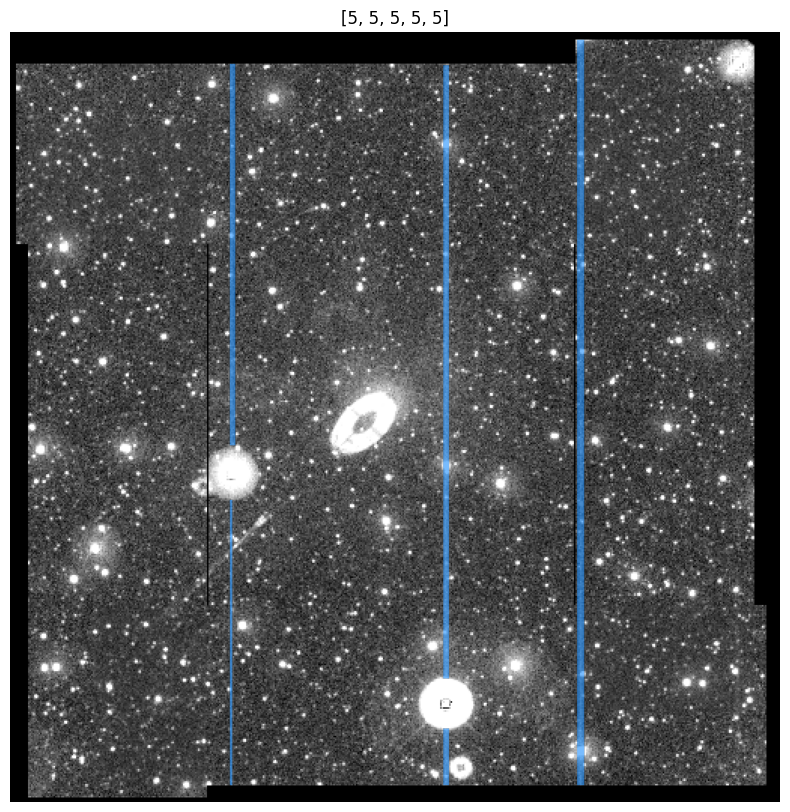

S0037980401_L_png


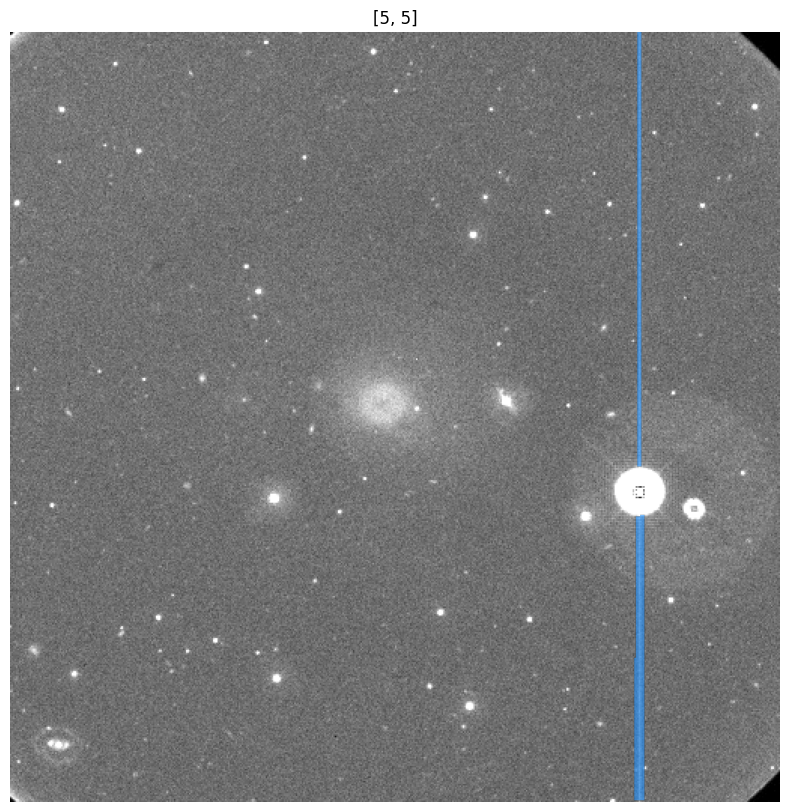

S0864080701_L_png


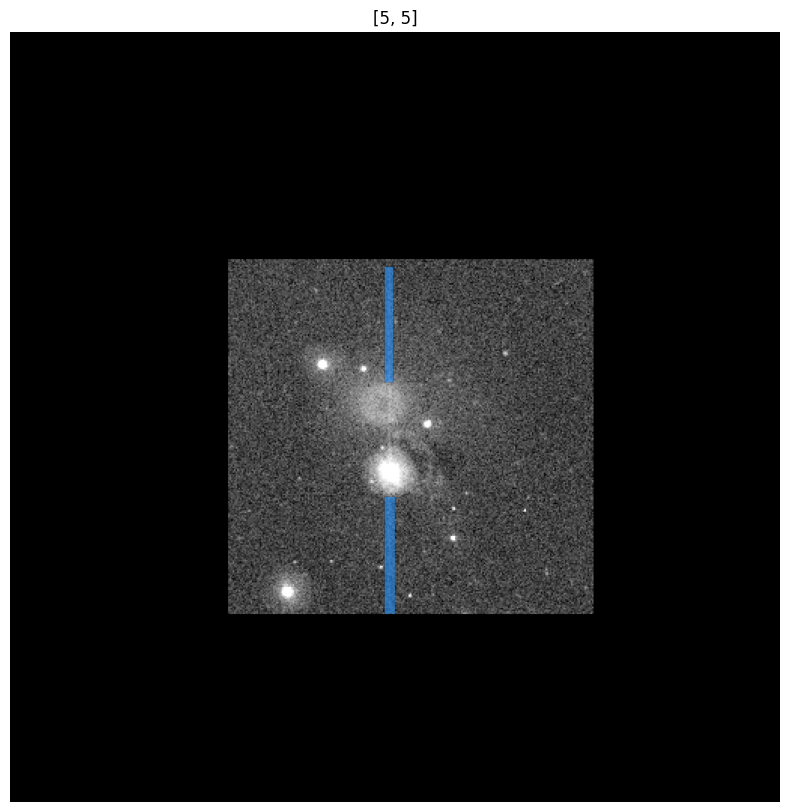

S0672130101_U_png


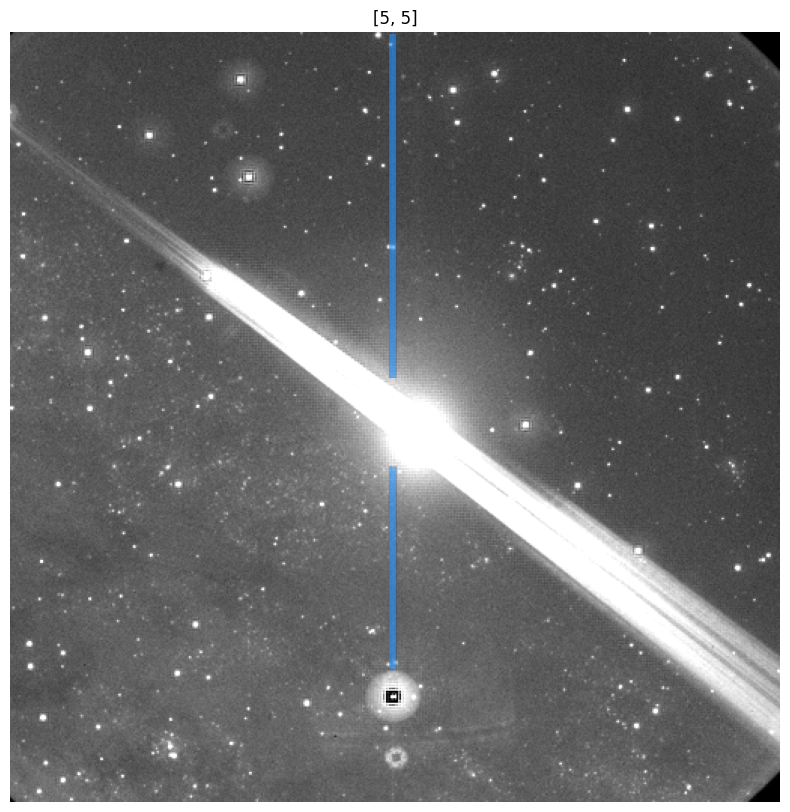

S0674380201_M_png


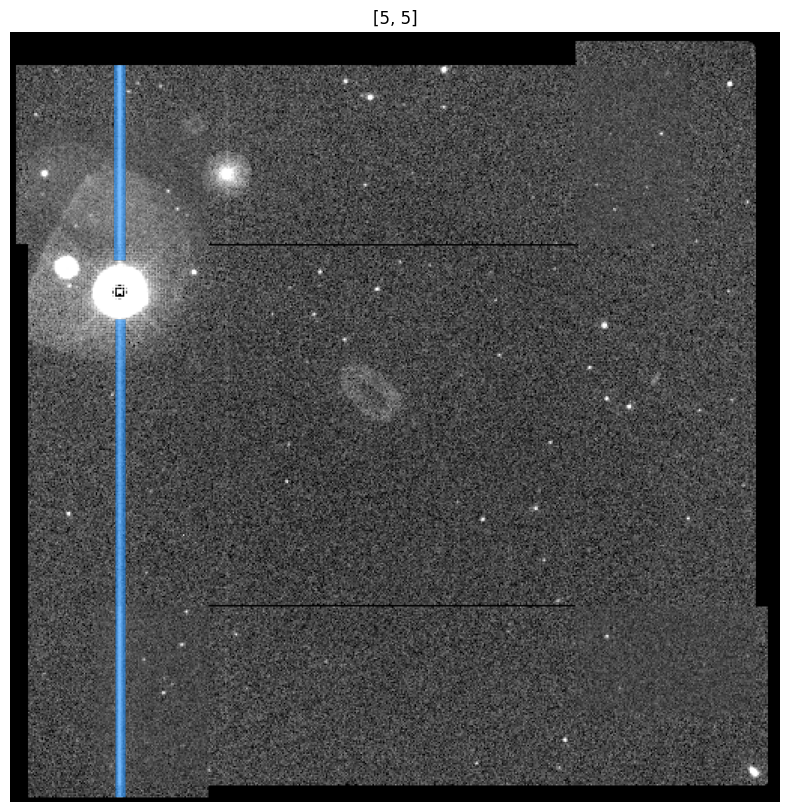

S0300140201_V_png


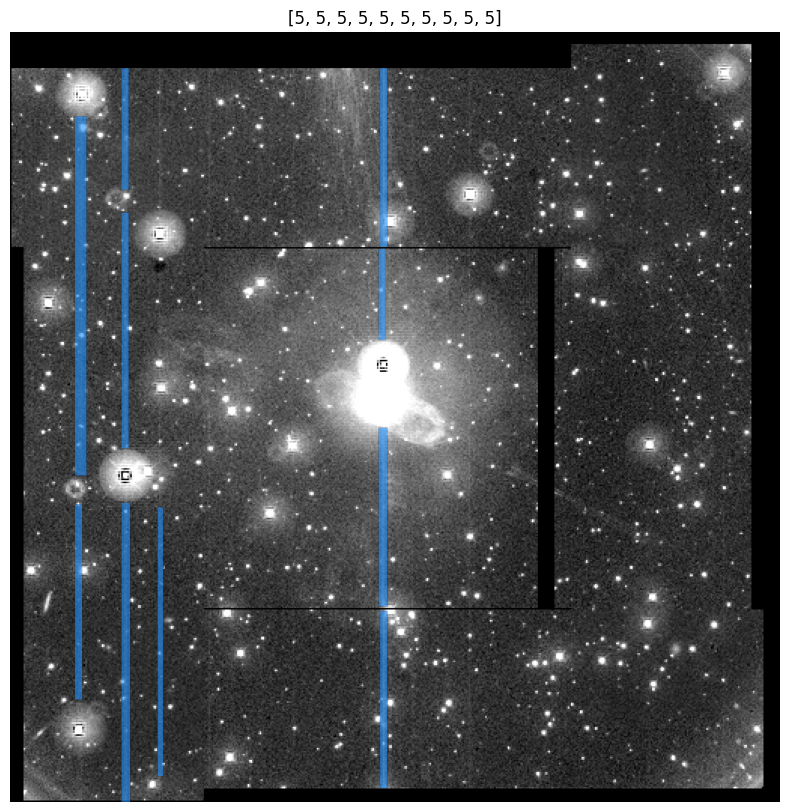

S0304201001_U_png



KeyboardInterrupt



In [207]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def show_masks(masks, ax, random_color=False):
    for mask in masks:
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.3])], axis=0)
        else:
                color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

def create_mask(points, image_size):
    polygon = [(points[i], points[i+1]) for i in range(0, len(points), 2)]
    mask = np.zeros(image_size, dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(polygon, dtype=np.int32)], 1)
    
    return mask
    
for key_i, value_i in ros_annots.items():
    image = cv2.imread('../XMM_OM_dataset/zscaled_512_stretched/'+key_i.replace('_png', '.png'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    print(key_i)
    masks = []
    cats = []
    for i in range(len(value_i)):
        masks.append(create_mask(value_i[i]['segmentation'][0], (512, 512)))
        cats.append(value_i[i]['category_id'])
        
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    show_masks(masks, plt.gca())
    plt.title(str(cats))
    plt.axis('off')  # Optionally remove the axes for display
    plt.show()
    plt.close()

In [1]:
image

NameError: name 'image' is not defined

# Import and visualize Roboflow annotations

This step assumes that you have downloaded the dataset locally, in COCO format. 

In [ ]:
if 0==1:
    
    def display_masks(image_path, masks):
        image = Image.open(image_path)
        plt.imshow(image)
        ax = plt.gca()
    
        for mask in masks:
            if isinstance(mask[0], list):  # If the mask is a polygon
                polygon_points = np.array(mask[0]).reshape(-1, 2)
                polygon = Polygon(polygon_points, edgecolor='g', facecolor='none')
                ax.add_patch(polygon)
            else:  # If the mask is RLE
                binary_mask = maskUtils.decode(mask)
                ax.imshow(binary_mask, alpha=0.5, cmap='gray')
        plt.show()
    
    dir_train_path = './xmm_om_images_v4-contrast-512-5-7/train/'
    json_file_path = dir_train_path+'_annotations.coco.json'
    
    with open(json_file_path, 'r') as f:
        data = json.load(f) 
    
    for image_info in data['images']:
        image_id = image_info['id']
        image_path = dir_train_path + image_info['file_name']
        
        annotations = [anno for anno in data['annotations'] if anno['image_id'] == image_id]
        # annotations: dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd'])
        
        masks = [anno['segmentation'] for anno in annotations]
        display_masks(image_path, masks)

# Mobile SAM inference

Here, the SAM Auto Mask Generator is used to predict masks on an input image. The predictor generates $32\times32$ grid points which represent foreground point input prompts for the mask decoder and filteres the best masks for prediciton. However, some methods are have the `torch.no_grad()` decorator thus such predictor cannot be trained. One idea would be to add gradients <i>on the way</i>, but it is risky and is not targeted for this moment.

In [ ]:
sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-master/') # MobileSAM repo path
import mobile_sam
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/MobileSAM-master/weights/mobile_sam.pt"
device = "cuda:3" if torch.cuda.is_available() else "cpu"
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device=device)
mobile_sam_model.eval();
device

In [ ]:
image_path = './roboflow_datasets/xmm_om_images_v4-contrast-512-5-7/train/S0037980401_L_png.rf.17cd9454f2c96e8a3e06676a49f2640b.jpg'
image_fits_path = '../XMM_OM_dataset/scaled_raw_512/S0037980401_L.fits'

mask_on_negative = predict.mask_and_plot_image(image_fits_path)
output_path = image_path.split('/')[-1].replace(".png", "_mobile_sam_nonnegative.png")
start_time = time.time()
image, mobile_sam_result = predict.MobileSAM_predict(
    image_path, 
    model=mobile_sam_model,
    predictor=SamPredictor,
    generator=SamAutomaticMaskGenerator,
    device=device, 
    output_path=output_path, 
    mask_on_negative=mask_on_negative)
end_time = time.time()
print(f"Mobile SAM predict time/img: {end_time-start_time} s")

plt.imshow(image)
plt.title('Mobile SAM pred. on image input')
plt.show()
plt.close()

# 🚀 Segment Anything Model (SAM)

## Install SAM model and dependencies

In [ ]:
# %cd {HOME}

# import sys
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

## Download SAM weights

In [ ]:
# %cd {HOME}
# !mkdir {HOME}/weights
# %cd {HOME}/weights

# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Load Model

In [ ]:
import os
HOME = os.getcwd()

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu') 
sam = sam_model_registry["vit_h"](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
sam.eval();

## 🚀 The predictor function (can remove masks on negative pixels)

In [ ]:
mask_on_negative = predict.mask_and_plot_image("../XMM_OM_dataset/scaled_raw_512/S0012850201_L.fits", plot_=True)

## AMG with extracted and deblended sources centroids

Generating 1024 points on an astronomical image may be redundant, as the usual Field of View contains way fewer noticeable sources. In this way, we can reduce inference time by using deblended sources centroids resulted from a source detection algorithm. This approach yields faster result but is sometimes less accurate.

In [ ]:
obs_id = 'S0801800201_L'
image_path = f"../XMM_OM_dataset/zscaled_512_stretched/{obs_id}.png"
mask_on_negative = predict.mask_and_plot_image(f"../XMM_OM_dataset/scaled_raw_512/{obs_id}.fits")
start_time = time.time()

with open('extracted_sources_bboxes_points.json', 'r') as f:
    extracted_bboxes_points = json.load(f)

img_points = np.array([point for filename, point in extracted_bboxes_points['points'].items() 
                       if obs_id in filename])/255.0

_, _, annotated_image1 = predict.SAM_predictor(
    SamAutomaticMaskGenerator, 
    sam, image_path, 
    mask_on_negative=mask_on_negative, 
    img_grid_points=None)
sam_grid_time = time.time()-start_time

img_points = np.array([point for filename, point in extracted_bboxes_points['points'].items() 
                       if filename in image_path.split("/")[-1]])/255
if len(img_points)>0:
    start_time = time.time()
    _, _, annotated_image2 = predict.SAM_predictor(
        SamAutomaticMaskGenerator, 
        sam, 
        image_path, 
        mask_on_negative=None, 
        img_grid_points=img_points)
    sam_with_detected_sources_time = time.time()-start_time
    
fig, axs= plt.subplots(1, 3, figsize=(10, 10)) 
axs[0].imshow(annotated_image1)
axs[0].set_title(f'Original SAM inference \ntime: {round(sam_grid_time, 3)}s, {1024} grid points', \
                 fontfamily='monospace', fontsize=10)

axs[1].imshow(annotated_image2)
axs[1].set_title(f'SAM inference \nwith deblended sources centroids \ntime: '+\
                 f'{round(sam_with_detected_sources_time, 3)}s, {img_points.shape[1]} grid points', \
                fontfamily='monospace', fontsize=10)

axs[2].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
axs[2].scatter(img_points[0][:, 0]*255, img_points[0][:, 1]*255, s=10, c='red')
axs[2].set_title(f'Extracted sources grid points', \
                 fontfamily='monospace', fontsize=10)
axs[2].set_aspect('equal', 'box')  
plt.tight_layout()
# plt.savefig('plots/sam_grid_points_comparison.png', dpi=300)
plt.show()
plt.close()

In [ ]:
generate_all_predictions = True

inference_times = []
if generate_all_predictions:
    dir_files = [f for f in os.listdir(OM_dir) if os.path.isfile(os.path.join(OM_dir, f))]
    for file_ in dir_files:
        try:
            if '.png' in file_:
                image_path = OM_dir+'/'+file_
                mask_on_negative = predict.mask_and_plot_image(image_path.replace('.png', '.fits'))
                start_time = time.time()
                
                with open('extracted_sources_bboxes_points.json', 'r') as f:
                    extracted_bboxes_points = json.load(f)
                
                img_points = np.array([point for filename, point in extracted_bboxes_points['points'].items() 
                                       if filename in image_path])/255.0
                
                _, _, annotated_image1 = predict.SAM_predictor(
                    SamAutomaticMaskGenerator, 
                    sam, 
                    image_path, 
                    mask_on_negative=mask_on_negative, 
                    img_grid_points=None)
                sam_grid_time = time.time()-start_time
                
                img_points = np.array([point for filename, point in extracted_bboxes_points['points'].items() 
                                       if filename in image_path.split("/")[-1]])/255
                if len(img_points)>0:
                    start_time = time.time()
                    _, _, annotated_image2 = predict.SAM_predictor(
                        SamAutomaticMaskGenerator, 
                        sam, 
                        image_path, 
                        mask_on_negative=None, 
                        img_grid_points=img_points)
                    sam_with_detected_sources_time = time.time()-start_time
                    
                fig, axs= plt.subplots(1, 3, figsize=(10, 10)) 
                axs[0].imshow(annotated_image1)
                axs[0].set_title(f'Original SAM inference \ntime: {round(sam_grid_time, 3)}s, {1024} grid points', \
                                 fontfamily='monospace', fontsize=10)
                
                axs[1].imshow(annotated_image2)
                axs[1].set_title(f'SAM inference \nwith deblended sources centroids \ntime: '+\
                     f'{round(sam_with_detected_sources_time, 3)}s, {img_points.shape[1]} grid points', \
                fontfamily='monospace', fontsize=10)
                
                axs[2].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
                axs[2].scatter(img_points[0][:, 0]*255, img_points[0][:, 1]*255, s=10, c='red')
                axs[2].set_title(f'Extracted sources grid points', \
                                 fontfamily='monospace', fontsize=10)
                axs[2].set_aspect('equal', 'box')  
                plt.tight_layout()
                # plt.savefig('plots/sam_grid_points_comparison.png', dpi=300)
                plt.show()
                plt.close()

        except Exception as e:
            print(e)
            pass
    
    # with open('cell_SAM_predict_with_threshold.txt', 'w') as f:
    #     f.write(str(cap))

## 🚀 Generate annotation json file (COCO format)

In [ ]:
import os
import json
import numpy as np
from datetime import datetime
from PIL import Image

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    print(box[0], box[1], box[2],  box[3]) 
    w, h = box[2], box[3] 
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: numpy_to_list(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    else:
        return obj

categories = []

# coco_style_annotations = {'categories': categories, 'images': [], 'annotations': []}
coco_style_annotations = {'annotations': []}

def get_SAM_annotations(IMAGE_PATH, mask_on_negative = None, output_mode="binary_mask"):
    """
    This function calls SAM (Segment Anything) and gets annotations for a given image.
    Args:
        IMAGE_PATH (str): The path to the image file.
        remove_masks_on_negative (bool, optional): If True, masks on negative detections are removed.

    Returns:
        tuple: A tuple containing the SAM results, detections, and the annotated image.
    """
    image_bgr = cv2.imread(IMAGE_PATH)
    annotated_image, detections, sam_result = None, None, None

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    mask_generator = SamAutomaticMaskGenerator(sam, output_mode=output_mode)
    
    sam_result = mask_generator.generate(image_rgb)
    if mask_on_negative is not None:
        sam_result = remove_masks(sam_result=sam_result,mask_on_negative=mask_on_negative, threshold=50)
        
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    detections = sv.Detections.from_sam(sam_result=sam_result)
    annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)
    
    return sam_result, detections, annotated_image

# Run SAM for image files in the directory and create the annotation json file in COCO format
def generate_json_file(input_dir, coco_style_annotations):
    for file_ in os.listdir(input_dir):
        if "png" in file_:
            mask_on_negative = mask_and_plot_image(input_dir+file_.replace('.png', '.fits'))
            sam_result_i, detections_i, annotated_image_i = get_SAM_annotations(input_dir+file_, mask_on_negative.astype(int))
            sam_result_i = numpy_to_list(sam_result_i)
            img = cv2.imread(os.path.join(input_dir, file_))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            height, width, _ = img.shape
            
            for annotation in sam_result_i:
                xyhw = annotation['bbox']
                
                # filter out very small/big objects
                if (xyhw[2] >2 or xyhw[3] >2) and (xyhw[2]*1.0/height < 0.7 and xyhw[3]*1.0/width < 0.7):
                    coco_style_annotations['annotations'].append({
                            'id': f'{file_.split(".")[0]}_mask{k}',
                            'image_id': file_.split('.')[0], 
                            'category_id': 0,  
                            'segmentation': annotation['segmentation'],
                            'area': annotation['area'],
                            'bbox': annotation['bbox'],
                            'iscrowd': 0,
                        })
                    k+=1
    
    with open('SAM_annotations_coco_style_v2.json', 'w') as f:
        json.dump(coco_style_annotations, f)

input_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw/'
generate_json_file(input_dir, coco_style_annotations)

## 🚀 Generate annotation json file (VOC format)

In [16]:
import glob
from roboflow import Roboflow

# Initialize Roboflow client
rf = Roboflow(api_key="EBeK30tpU3HW2VGGl0xa")
upload_project = rf.workspace("iuliaelisa").project("xmm_om_artefacts") # error if the project doesn't exist

loading Roboflow workspace...
loading Roboflow project...


### Create and export SAM annotations in VOC format to Roboflow

In [ ]:
import dataset, class_agnostic_sam_predictor
from class_agnostic_sam_predictor import predictor_utils as predict
from dataset import voc_annotate_and_Roboflow_export as voc

input_dir = './temp_images/'

k=0
if 1==1:
    input_fits_dir = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'
    for file_ in os.listdir(input_dir):
        if k>1:
            break
        else:
            k+=1
            mask_on_negative = predict.mask_and_plot_image(input_fits_dir+file_.replace('.png', '.fits'), plot_=False)
            sam_result_i, detections_i, annotated_image_i = predict.SAM_predictor(SamAutomaticMaskGenerator, sam, input_dir+file_, 
                                                                          mask_on_negative=mask_on_negative, img_grid_points=None)
            if sam_result_i is not None and detections_i is not None and annotated_image_i is not None:
                objects = []
                for annotation in sam_result_i: # a mask over an image is a binary array with shape (img_h, img_w)
                    polygon = voc.binary_image_to_polygon(annotation['segmentation'])
                    # plot_polygon(polygon[0], annotated_image_i) # to see the masks polygons
                    objects.append({
                        'name': 'star',
                        'bbox': annotation['bbox'],
                        'segmentations': polygon[0]
                    })

                print(file_)
                voc.create_annotation_SAM(filename=file_, width=512, height=512, depth=3, objects=objects) # generating xml file for VOC format
                image_path = input_dir+file_
                annotation_filename = file_.replace(".png", ".xml")
                
                upload_project.upload(image_path, annotation_filename, overwrite=False)
                os.remove(annotation_filename)

### Convert annotations from **COCO** format to VOC and mount to Roboflow

In [10]:
import json 
import dataset
from dataset import voc_annotate_and_Roboflow_export as voc, dataset_utils as data_set

import os
input_dir = "./roboflow_datasets/xmm_om_artefacts_512-27/train/"
json_file_path = input_dir+'_annotations.coco.json'

zscaled = '../XMM_OM_dataset/zscaled_512_stretched/'
with open(json_file_path) as f:
    new_data_in = json.load(f)

In [3]:
# new_data_in['categories'][4]['supercategory'] = 'artefacts-GLut'

In [4]:
new_data_in['categories']

[{'id': 0, 'name': 'artefacts', 'supercategory': 'artefact'},
 {'id': 1, 'name': 'central-ring', 'supercategory': 'artefact'},
 {'id': 2, 'name': 'other', 'supercategory': 'artefact'},
 {'id': 3, 'name': 'read-out-streak', 'supercategory': 'artefact'},
 {'id': 4, 'name': 'smoke-ring', 'supercategory': 'artefact'},
 {'id': 5, 'name': 'star-loop', 'supercategory': 'artefact'}]

In [14]:
len(new_data_in['images'])

960

In [19]:
k=0
if 1==1:
    for im in new_data_in['images']:  
            objects = []
            file_ = im['file_name']
            extension = "."+file_.split(".")[-1]
        
            masks = [new_data_in['annotations'][a] for a in range(len(new_data_in['annotations'])) if new_data_in['annotations'][a]['image_id'] == im['id']]
            classes = [new_data_in['annotations'][a]['category_id'] for a in range(len(new_data_in['annotations'])) if new_data_in['annotations'][a]['image_id'] == im['id']]
            class_categories = {new_data_in['categories'][a]['id']:new_data_in['categories'][a]['name'] for a in range(len(new_data_in['categories']))}
            temp_img = cv2.imread(input_dir+im["file_name"])
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
            cv2.imwrite(f"./{file_.replace('_png', '.png')}", temp_img)

            if len(masks)==0: # null image
                image_path = file_.replace('_png', '.png').split('.')[0]+'.png'
                print("NULL image ", k, image_path)
                k+=1
                upload_project.upload(os.path.join(zscaled, image_path))
            continue

            for i in range(len(masks)):
                segmentation = masks[i]['segmentation']
                if isinstance(segmentation, list):
                    if len(segmentation) > 0 and isinstance(segmentation[0], list):
                        points = segmentation[0]
                        h_img, w_img = temp_img.shape[:2]
                binary_m = data_set.create_mask(points, (h_img, w_img)) # COCO segmentations are polygon points, and must be converted to masks
                
                points = np.array(masks[i]['segmentation']).reshape(-1, 2)
                x_min, y_min = np.inf, np.inf
                x_max, y_max = -np.inf, -np.inf
                x_min = min(x_min, points[:, 0].min())
                y_min = min(y_min, points[:, 1].min())
                x_max = max(x_max, points[:, 0].max())
                y_max = max(y_max, points[:, 1].max())
        
                # Calculate width and height
                width = x_max - x_min
                height = y_max - y_min
                # The bbox in COCO format [x_min, y_min, width, height]
                bbox = [x_min, y_min, width, height]
                objects.append({
                    'name': class_categories[classes[i]],
                    'bbox': bbox, #data_set.mask_to_bbox(binary_m),
                    'segmentations': segmentation[0]
                })

            voc.create_annotation(
                filename=file_.replace('_png', '.png'), 
                width=512, 
                height=512, 
                depth=3, 
                objects=objects, 
                offset=1.0) # generating xml file for VOC format 
            image_path_r = file_.replace('_png', '.png')
            image_path = file_.replace('_png', '.png').split('.')[0]+'.png'
            annotation_filename = file_.replace('_png', '.png').replace(extension, ".xml")
            new_lines = ['<annotation>\n','	<folder></folder>\n']
            
            with open(annotation_filename, 'r') as file:
                lines = file.readlines()
            
            del lines[:3]
            
            modified_lines = new_lines + lines
            
            with open(annotation_filename, 'w') as file:
                file.writelines(modified_lines)

            upload_project.upload(os.path.join(zscaled, image_path), annotation_filename, overwrite=True)
            del temp_img
            os.remove(annotation_filename)
            os.remove(image_path_r)

NULL image  0 S0201130201_M.png
NULL image  1 S0057740301_S.png
NULL image  2 S0504101601_S.png
NULL image  3 S0771000101_S.png
NULL image  4 S0727571601_S.png
NULL image  5 S0084230701_S.png
NULL image  6 S0556215201_M.png
NULL image  7 S0782500201_M.png
NULL image  8 S0148740201_S.png
NULL image  9 S0555220101_S.png
NULL image  10 S0552340101_M.png
NULL image  11 S0207060301_M.png
NULL image  12 S0111280301_M.png
NULL image  13 S0556212201_M.png
NULL image  14 S0312190201_M.png
NULL image  15 S0123920101_S.png
NULL image  16 S0721630101_S.png
NULL image  17 S0311590801_S.png
NULL image  18 S0863230101_M.png
NULL image  19 S0785102401_S.png
NULL image  20 S0748390901_M.png
NULL image  21 S0827041801_M.png
NULL image  22 S0552170301_S.png
NULL image  23 S0844860301_L.png
NULL image  24 S0303420201_S.png
NULL image  25 S0154350201_M.png
NULL image  26 S0844860301_S.png
NULL image  27 S0791581101_S.png
NULL image  28 S0881990201_S.png
NULL image  29 S0505140401_M.png
NULL image  30 S0741

### Export images and VOC annotations in VOC format to Roboflow (2)

In [ ]:
import requests
import os

import glob
from roboflow import Roboflow

rf = Roboflow(api_key="my_api_key")
upload_project = rf.workspace("my_username").project("roboflow_project")

dataset_images_folder = '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/zscaled_512_stretched/'
annotations_voc_dir = '/workspace/raid/OM_DeepLearning/XAMI/xmm_om_images_v4-contrast-512-1/train/'
annotations_ = []

for annot in os.listdir(annotations_voc_dir):
    if annot.endswith('.xml'):
        annotations_.append(annot)

for image_name in os.listdir(dataset_images_folder):
    image_path = os.path.join(dataset_images_folder, image_name)
    if os.path.isfile(image_path):
        print(image_path.split('/')[-1].replace('.', '_'))
        annotations_voc_filename = [annotation for annotation in annotations_ if annotation.startswith(image_path.split('/')[-1].replace('.', '_'))]
        if len(annotations_voc_filename):
            upload_project.upload(image_path, annotations_voc_dir+annotations_voc_filename[0], overwrite=True)

print("Image upload complete.")